In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 2s 0us/step


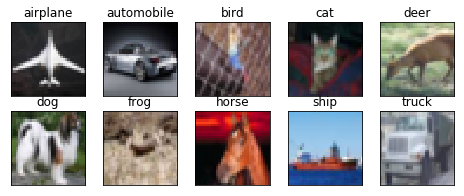

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
# Define the model
from keras import regularizers
from keras.layers import Input, Lambda
from keras.layers.merge import concatenate
from keras.models import Model
from keras.layers.convolutional import SeparableConv2D, AveragePooling2D
import tensorflow as tf

def space_to_depth(x):
  return tf.space_to_depth(x, 2)

visible = Input(shape=(32,32,3)) 

sep1 = SeparableConv2D(8, 5, 5, border_mode = 'same', name = 'sep_1', kernel_regularizer=regularizers.l2(0.0001))(visible) 
sep1 = BatchNormalization()(sep1)
sep1 = Activation('relu')(sep1)
sep1 = Dropout(0.10)(sep1)

conv1 = Conv2D(8, 5, 5, border_mode = 'same', name = 'conv_1', kernel_regularizer=regularizers.l2(0.0001))(sep1) 
conv1 = BatchNormalization()(conv1)
conv1 = Activation('relu')(conv1)
conv1 = Dropout(0.10)(conv1)

conv2 = Conv2D(8, 5, 5, border_mode = 'same', name = 'conv_2', kernel_regularizer=regularizers.l2(0.0001))(conv1) 
conv2 = BatchNormalization()(conv2)
conv2 = Activation('relu')(conv2)
conv2 = Dropout(0.10)(conv2)

merge1 = concatenate([sep1,conv2], name = 'merge_1')

conv1x1_1 = Conv2D(8, 1, 1, name = 'conv1x1_1', kernel_regularizer=regularizers.l2(0.0001))(merge1) 
conv1x1_1 = BatchNormalization()(conv1x1_1)
conv1x1_1 = Activation('relu')(conv1x1_1)
conv1x1_1 = Dropout(0.10)(conv1x1_1)

sep2 = SeparableConv2D(16, 5, 5, border_mode = 'same', name = 'sep_2', kernel_regularizer=regularizers.l2(0.0001))(conv1x1_1) 
sep2 = BatchNormalization()(sep2)
sep2 = Activation('relu')(sep2)
sep2 = Dropout(0.10)(sep2)

merge2 = concatenate([sep1,sep2], name = 'merge_2')

conv1x1_2 = Conv2D(16, 1, 1, name = 'conv1x1_2', kernel_regularizer=regularizers.l2(0.0001))(merge2) 
conv1x1_2 = BatchNormalization()(conv1x1_2)
conv1x1_2 = Activation('relu')(conv1x1_2)
conv1x1_2 = Dropout(0.10)(conv1x1_2)

pool1 = MaxPooling2D(pool_size=(2, 2), name = 'pool_1')(conv1x1_2)

sep3 = SeparableConv2D(16, 3, 3, border_mode = 'same', name = 'sep_3', kernel_regularizer=regularizers.l2(0.0001))(pool1)
sep3 = BatchNormalization()(sep3)
sep3 = Activation('relu')(sep3)
sep3 = Dropout(0.10)(sep3)

space_to_depth_merge2 = Lambda(space_to_depth, name = 'space_to_depth_merge2')(merge2)
merge3 = concatenate([space_to_depth_merge2,sep3], name = 'merge_3')

conv1x1_3 = Conv2D(16, 1, 1, name = 'conv1x1_3', kernel_regularizer=regularizers.l2(0.0001))(merge3) 
conv1x1_3 = BatchNormalization()(conv1x1_3)
conv1x1_3 = Activation('relu')(conv1x1_3)
conv1x1_3 = Dropout(0.10)(conv1x1_3)

conv3 = Conv2D(32, 5, 5, border_mode = 'same', name = 'conv_3', kernel_regularizer=regularizers.l2(0.0001))(conv1x1_3)
conv3 = BatchNormalization()(conv3)
conv3 = Activation('relu')(conv3)
conv3 = Dropout(0.10)(conv3)

space_to_depth_conv2_1 = Lambda(space_to_depth, name = 'space_to_depth_conv2_1')(conv2)
space_to_depth_sep2 = Lambda(space_to_depth, name = 'space_to_depth_sep2')(sep2)
merge4 = concatenate([space_to_depth_conv2_1,conv3,space_to_depth_sep2], name = 'merge_4')

conv1x1_4 = Conv2D(32, 1, 1, name = 'conv1x1_4', kernel_regularizer=regularizers.l2(0.0001))(merge4) 
conv1x1_4 = BatchNormalization()(conv1x1_4)
conv1x1_4 = Activation('relu')(conv1x1_4)
conv1x1_4 = Dropout(0.10)(conv1x1_4)

sep4 = SeparableConv2D(32, 3, 3, border_mode = 'same', name = 'sep_4', kernel_regularizer=regularizers.l2(0.0001))(conv1x1_4) 
sep4 = BatchNormalization()(sep4)
sep4 = Activation('relu')(sep4)
sep4 = Dropout(0.10)(sep4)

merge5 = concatenate([sep4,merge3,space_to_depth_conv2_1,conv3], name = 'merge_5')

conv1x1_5 = Conv2D(32, 1, 1, name = 'conv1x1_5', kernel_regularizer=regularizers.l2(0.0001))(merge5) 
conv1x1_5 = BatchNormalization()(conv1x1_5)
conv1x1_5 = Activation('relu')(conv1x1_5)
conv1x1_5 = Dropout(0.10)(conv1x1_5)

sep5 = SeparableConv2D(64, 5, 5, border_mode = 'same', name = 'sep_5', kernel_regularizer=regularizers.l2(0.0001))(conv1x1_5) 
sep5 = BatchNormalization()(sep5)
sep5 = Activation('relu')(sep5)
sep5 = Dropout(0.10)(sep5)

merge6 = concatenate([space_to_depth_sep2,sep3,sep4,sep5], name = 'merge_6')

conv1x1_6 = Conv2D(64, 1, 1, name = 'conv1x1_6', kernel_regularizer=regularizers.l2(0.0001))(merge6) 
conv1x1_6 = BatchNormalization()(conv1x1_6)
conv1x1_6 = Activation('relu')(conv1x1_6)
conv1x1_6 = Dropout(0.10)(conv1x1_6)

pool2 = MaxPooling2D(pool_size=(2, 2), name = 'pool_2')(conv1x1_6)

space_to_depth_conv3 = Lambda(space_to_depth, name = 'space_to_depth_conv3')(conv3)
merge7 = concatenate([pool2,space_to_depth_conv3], name = 'merge_7')

conv1x1_7 = Conv2D(64, 1, 1, name = 'conv1x1_7', kernel_regularizer=regularizers.l2(0.0001))(merge7) 
conv1x1_7 = BatchNormalization()(conv1x1_7)
conv1x1_7 = Activation('relu')(conv1x1_7)
conv1x1_7 = Dropout(0.10)(conv1x1_7)

conv4 = Conv2D(64, 5, 5, border_mode = 'same', name = 'conv_4', kernel_regularizer=regularizers.l2(0.0001))(conv1x1_7) 
conv4 = BatchNormalization()(conv4)
conv4 = Activation('relu')(conv4)
conv4 = Dropout(0.10)(conv4)

space_to_depth_conv1_1 = Lambda(space_to_depth, name = 'space_to_depth_conv1_1')(conv1)
space_to_depth_conv1_2 = Lambda(space_to_depth, name = 'space_to_depth_conv1_2')(space_to_depth_conv1_1)
space_to_depth_sep1_1 = Lambda(space_to_depth, name = 'space_to_depth_sep1_1')(sep1)
space_to_depth_sep1_2 = Lambda(space_to_depth, name = 'space_to_depth_sep1_2')(space_to_depth_sep1_1)
space_to_depth_sep4 = Lambda(space_to_depth, name = 'space_to_depth_sep4')(sep4)
merge8 = concatenate([conv4,space_to_depth_sep4,space_to_depth_conv1_2,space_to_depth_sep1_2], name = 'merge_8')

conv1x1_8 = Conv2D(128, 1, 1, name = 'conv1x1_8', kernel_regularizer=regularizers.l2(0.0001))(merge8) 
conv1x1_8 = BatchNormalization()(conv1x1_8)
conv1x1_8 = Activation('relu')(conv1x1_8)
conv1x1_8 = Dropout(0.10)(conv1x1_8)

sep6 = SeparableConv2D(128, 5, 5, border_mode = 'same', name = 'sep_6', kernel_regularizer=regularizers.l2(0.0001))(conv1x1_8) 
sep6 = BatchNormalization()(sep6)
sep6 = Activation('relu')(sep6)
sep6 = Dropout(0.10)(sep6)

space_to_depth_conv2_2 = Lambda(space_to_depth, name = 'space_to_depth_conv2_2')(space_to_depth_conv2_1)
space_to_depth_sep3 = Lambda(space_to_depth, name = 'space_to_depth_sep3')(sep3)
merge9 = concatenate([sep6,conv4,space_to_depth_conv2_2,space_to_depth_conv1_2,space_to_depth_sep3], name = 'merge_9')

conv1x1_9 = Conv2D(128, 1, 1, name = 'conv1x1_9', kernel_regularizer=regularizers.l2(0.0001))(merge9) 
conv1x1_9 = BatchNormalization()(conv1x1_9)
conv1x1_9 = Activation('relu')(conv1x1_9)
conv1x1_9 = Dropout(0.10)(conv1x1_9)

conv5 = Conv2D(128, 3, 3, border_mode = 'same', name = 'conv_5', kernel_regularizer=regularizers.l2(0.0001))(conv1x1_9) 
conv5 = BatchNormalization()(conv5)
conv5 = Activation('relu')(conv5)
conv5 = Dropout(0.10)(conv5)

space_to_depth_merge3 = Lambda(space_to_depth, name = 'space_to_depth_merge3')(merge3)
merge10 = concatenate([conv5,space_to_depth_conv2_2,space_to_depth_sep4,sep6,space_to_depth_merge3], name = 'merge_10')

conv1x1_10 = Conv2D(128, 1, 1, name = 'conv1x1_10', kernel_regularizer=regularizers.l2(0.0001))(merge10) 
conv1x1_10 = BatchNormalization()(conv1x1_10)
conv1x1_10 = Activation('relu')(conv1x1_10)
conv1x1_10 = Dropout(0.10)(conv1x1_10)

sep7 = SeparableConv2D(10, 5, 5, border_mode = 'same', name = 'sep_7', kernel_regularizer=regularizers.l2(0.0001))(conv1x1_10)
sep7 = BatchNormalization()(sep7)
sep7 = Activation('relu')(sep7)
sep7 = Dropout(0.10)(sep7)

avgpool = AveragePooling2D(8,8, name = 'avg_pool')(sep7)

avgpool = Flatten()(avgpool)

output = Activation('softmax')(avgpool)

model = Model(inputs=visible, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(8, (5, 5), name="sep_1", kernel_regularizer=<keras.reg..., padding="same")`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (5, 5), name="conv_1", kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (5, 5), name="conv_2", kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (1, 1), name="conv1x1_1", kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `Separabl

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_43 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
sep_1 (SeparableConv2D)         (None, 32, 32, 8)    107         input_43[0][0]                   
__________________________________________________________________________________________________
batch_normalization_498 (BatchN (None, 32, 32, 8)    32          sep_1[0][0]                      
__________________________________________________________________________________________________
activation_522 (Activation)     (None, 32, 32, 8)    0           batch_normalization_498[0][0]    
__________________________________________________________________________________________________
dropout_49

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=100)`
  if sys.path[0] == '':


Epoch 1/100
390/390 [==============================] - 49s 125ms/step - loss: 1.7217 - acc: 0.4634 - val_loss: 1.5576 - val_acc: 0.5155
Epoch 2/100
390/390 [==============================] - 30s 77ms/step - loss: 1.2790 - acc: 0.6205 - val_loss: 1.3657 - val_acc: 0.5752
Epoch 3/100
390/390 [==============================] - 30s 76ms/step - loss: 1.0750 - acc: 0.6841 - val_loss: 1.1552 - val_acc: 0.6474
Epoch 4/100
390/390 [==============================] - 30s 76ms/step - loss: 0.9579 - acc: 0.7220 - val_loss: 1.0198 - val_acc: 0.6913
Epoch 5/100
390/390 [==============================] - 30s 76ms/step - loss: 0.8753 - acc: 0.7501 - val_loss: 1.0710 - val_acc: 0.6809
Epoch 6/100
390/390 [==============================] - 30s 77ms/step - loss: 0.8112 - acc: 0.7702 - val_loss: 1.1057 - val_acc: 0.6815
Epoch 7/100
390/390 [==============================] - 30s 76ms/step - loss: 0.7733 - acc: 0.7824 - val_loss: 1.1530 - val_acc: 0.6562
Epoch 8/100
390/390 [==============================] -

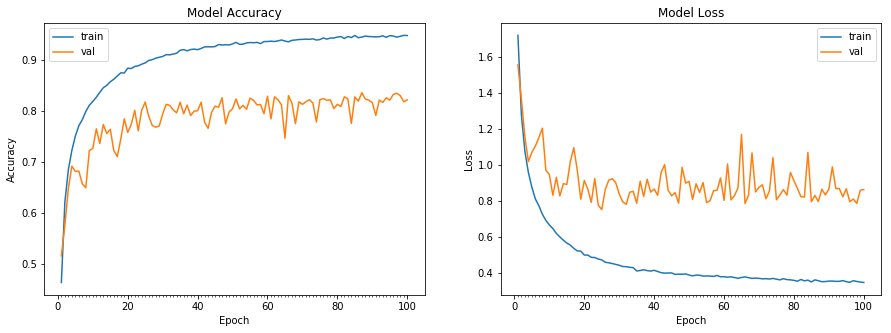

Accuracy on test data is: 82.10


In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))